# Project 7 - Length of Stay Model

**Author: Linh Nguyen/Sam Holt**<br>

**StudentID: 23161711/23087175**<br>

**Date: Oct 2022**

## 1. Load data and import package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone/

Mounted at /content/drive
/content/drive/MyDrive/Capstone


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report, roc_auc_score
# tf.compat.v1.disable_v2_behavior()


In [ ]:
keras.__version__

'2.9.0'

In [ ]:
! ls

Admission_ForXGB.csv			 subjects_entering.csv
BioWordVec_PubMed_MIMICIII_d200.vec.bin  subjects_leaving.csv
edstay_ad1.csv				 test_samples_chief.csv
edstays.csv				 test_samples_his.csv
edstays_preparation.ipynb		 top198historical_icd.csv
edstays_updated.csv			 train_samples_o.csv
length_of_stay_dataprep.csv		 triage.csv
LengthOfStay_ForXGB.csv			 updated_edstay_ad.csv
model.png				 vitalsign.csv
MORTALITY_EDSTAYS_TRIAGE_LASTVITALS.csv  x_test.csv
previous_icd_code.csv			 x_test_his.csv
pyxis.csv				 x_test_o.csv


# 2. Data cleansing


In [ ]:
edstays = pd.read_csv('edstays_updated.csv')
edstays['y_var_adm_text'] = edstays['disposition']
edstays['intime_h'] = pd.to_datetime(edstays.intime).dt.hour
edstays.loc[edstays['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'ADMITTED'
edstays.loc[edstays['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'MISSING'
edstays_admit = edstays[edstays['y_var_adm_text'] !='MISSING'].reset_index(drop = True)
edstays_admit['key'] = edstays_admit['subject_id'].astype(str)+'_'+edstays_admit['stay_id'].astype(str)
edstays_admit.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime',
       'gender', 'race', 'arrival_transport', 'disposition', 'in_date',
       'out_date', 'race_class', 'hour', 'work_hours', 'subjects_entering',
       'subjects_leaving', 'y_var_adm_text', 'intime_h', 'key'],
      dtype='object')

In [ ]:
edstays_admit['DateTime_in'] = pd.to_datetime(edstays_admit['intime'], format='%Y-%m-%d %H:%M:%S')
edstays_admit['DateTime_out'] = pd.to_datetime(edstays_admit['outtime'], format='%Y-%m-%d %H:%M:%S')
edstays_admit['stay'] = edstays_admit['DateTime_out'] - edstays_admit['DateTime_in']

In [ ]:
edstays_admit_1 = edstays_admit.sort_values(by = ['subject_id','intime'], ascending=True).reset_index(drop=True)
edstays_admit_1['prior_visits'] = edstays_admit_1.groupby(['subject_id']).cumcount()
edstays_admit_1['in_date'] = pd.to_datetime(edstays_admit_1['in_date'])

edstays_admit_1 = edstays_admit_1.sort_values(by='in_date', ascending=True)
edstays_admit_1['daily_patients'] = edstays_admit_1.groupby(['in_date']).cumcount() + 1
edstays_admit_1[['subject_id','stay_id','in_date','prior_visits', 'daily_patients']].head(100)

,subject_id,stay_id,in_date,prior_visits,daily_patients
100742,12366195,39593933,2110-01-02,0,1
383147,18939097,39389792,2110-01-02,0,2
384488,18970562,34955418,2110-01-02,0,3
421977,19852597,38694233,2110-01-03,0,1
90844,12132996,30065258,2110-01-03,0,2
...,...,...,...,...,...
40880,10966847,34149803,2110-01-20,0,1
193472,14521817,33011140,2110-01-20,0,2
349958,18164210,38008035,2110-01-20,0,3
79877,11884229,33266347,2110-01-20,0,4


In [ ]:
edstays_admit_1 = edstays_admit_1.sort_values(by = ['subject_id','intime'], ascending=True).reset_index(drop=True)
edstay_hist = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_hist[i] = 'NO HISTORY'
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_hist[i] = edstays_admit_1['y_var_adm_text'][i-1]
        else:
            edstay_hist[i] = 'NO HISTORY'

In [ ]:
edstay_laststay = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_laststay[i] = np.timedelta64(0, 'D')
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]: 
          edstay_laststay[i] = edstays_admit_1['stay'][i-1]+edstay_laststay[i-1]
        else:
            edstay_laststay[i] = np.timedelta64(0, 'D')

In [ ]:
df1 = pd.DataFrame.from_dict(edstay_hist,orient='index')
df1.columns = ['historical_stay_status']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 
edstays_admit_1.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime',
       'gender', 'race', 'arrival_transport', 'disposition', 'in_date',
       'out_date', 'race_class', 'hour', 'work_hours', 'subjects_entering',
       'subjects_leaving', 'y_var_adm_text', 'intime_h', 'key', 'DateTime_in',
       'DateTime_out', 'stay', 'prior_visits', 'daily_patients',
       'historical_stay_status'],
      dtype='object')

In [ ]:
df1 = pd.DataFrame.from_dict(edstay_laststay,orient='index')
df1.columns = ['historical_stay_length']
edstays_admit_1b = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 
edstays_admit_1b.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime',
       'gender', 'race', 'arrival_transport', 'disposition', 'in_date',
       'out_date', 'race_class', 'hour', 'work_hours', 'subjects_entering',
       'subjects_leaving', 'y_var_adm_text', 'intime_h', 'key', 'DateTime_in',
       'DateTime_out', 'stay', 'prior_visits', 'daily_patients',
       'historical_stay_status', 'historical_stay_length'],
      dtype='object')

In [ ]:
edstays_admit_1b['historical_stay_length_in_day'] = edstays_admit_1b['historical_stay_length']/(np.timedelta64(1, 'D'))
edstays_admit_1b.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime',
       'gender', 'race', 'arrival_transport', 'disposition', 'in_date',
       'out_date', 'race_class', 'hour', 'work_hours', 'subjects_entering',
       'subjects_leaving', 'y_var_adm_text', 'intime_h', 'key', 'DateTime_in',
       'DateTime_out', 'stay', 'prior_visits', 'daily_patients',
       'historical_stay_status', 'historical_stay_length',
       'historical_stay_length_in_day'],
      dtype='object')

In [ ]:
# edstays_admit_2 = pd.merge(edstays_admit_1,edstays_admit_1b[['historical_stay_length_in_day','subject_id','stay_id']],how = 'left',on=['subject_id', 'stay_id'])
edstays_admit_2 = edstays_admit_1b.copy()

In [ ]:
edstays_admit_2.stay

0        30 days 04:46:00
1         0 days 04:13:00
2         0 days 05:37:00
3         0 days 13:30:00
4         0 days 08:06:00
               ...       
428279   29 days 06:26:00
428280    0 days 04:25:00
428281    1 days 00:16:00
428282    0 days 09:01:00
428283    0 days 03:31:00
Name: stay, Length: 428284, dtype: timedelta64[ns]

In [ ]:
triage = pd.read_csv('triage.csv')

def rescale_temp(x):
    if x > 200:
        return x/10
    else:
        return x
triage['temperature'] = [rescale_temp(x) for x in triage['temperature']]

def rescale_heart(x):
    if x > 300:
        return x / 100
    else:
        return x
    
triage['heartrate'] = [rescale_heart(x) for x in triage['heartrate']]

def rescale_pain(x):
    try:
        x = int(x)
        if x > 100:
            return 10
        elif x > 10:
            return x/10
        elif x < 0:
            return 0
        else:
            return x
    except:
        return None
    
triage['pain'] = [rescale_pain(x) for x in triage['pain']]
triage['pain'] = pd.to_numeric(triage['pain'])

In [ ]:
edstay_ad = pd.merge(edstays_admit_2,triage,how = 'left',on=['subject_id', 'stay_id'])

In [ ]:
edstay_ad = edstay_ad[edstay_ad['y_var_adm_text'].isin(['ADMITTED','HOME'])] 

In [ ]:
edstay_ad['y_var'] = 0
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'ADMITTED', 'y_var']  = 1

In [ ]:
# we need to reintroduce sub/stay ID, get a copy of triage3 sub/stay id order, left join to triage3 (for order) and then remove
# all because the y labels are attached to triage3
edstay_ad1 = edstay_ad.drop(['Unnamed: 0','hadm_id','intime', 'intime_h','outtime','race', 'disposition','y_var_adm_text','key', 'DateTime_in', 'DateTime_out','stay','historical_stay_length','chiefcomplaint', 'y_var',
                             'subjects_entering', 'subjects_leaving', 'intime', 'in_date','out_date'], axis = 1)

In [ ]:
edstay_ad1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428284 entries, 0 to 428283
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   subject_id                     428284 non-null  int64  
 1   stay_id                        428284 non-null  int64  
 2   gender                         428284 non-null  object 
 3   arrival_transport              428284 non-null  object 
 4   race_class                     428284 non-null  object 
 5   hour                           428284 non-null  int64  
 6   work_hours                     428284 non-null  int64  
 7   prior_visits                   428284 non-null  int64  
 8   daily_patients                 428284 non-null  int64  
 9   historical_stay_status         428284 non-null  object 
 10  historical_stay_length_in_day  428284 non-null  float64
 11  temperature                    405762 non-null  float64
 12  heartrate                     

In [ ]:
updated_edstay_ad = edstay_ad1
updated_edstay_ad['temperaturemissing'] = updated_edstay_ad['temperature'].isnull().astype(int)
updated_edstay_ad['heartratemissing'] = updated_edstay_ad['heartrate'].isnull().astype(int)
updated_edstay_ad['respratemissing'] = updated_edstay_ad['resprate'].isnull().astype(int)
updated_edstay_ad['o2satmissing'] = updated_edstay_ad['o2sat'].isnull().astype(int)
updated_edstay_ad['sbpmissing'] = updated_edstay_ad['sbp'].isnull().astype(int)
updated_edstay_ad['dbpmissing'] = updated_edstay_ad['dbp'].isnull().astype(int)
updated_edstay_ad['acuitymissing'] = updated_edstay_ad['acuity'].isnull().astype(int)

In [ ]:
num_attr = edstay_ad1.select_dtypes(include=['float64', 'int64']).columns
cat_attr = edstay_ad1.select_dtypes(include=['O']).columns
#bool_attr = edstay_ad.select_dtypes(include=['bool']).columns

In [ ]:
my_imputer = SimpleImputer(strategy = 'median')
updated_edstay_ad[num_attr] = my_imputer.fit_transform(updated_edstay_ad[num_attr])
updated_edstay_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428284 entries, 0 to 428283
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   subject_id                     428284 non-null  float64
 1   stay_id                        428284 non-null  float64
 2   gender                         428284 non-null  object 
 3   arrival_transport              428284 non-null  object 
 4   race_class                     428284 non-null  object 
 5   hour                           428284 non-null  float64
 6   work_hours                     428284 non-null  float64
 7   prior_visits                   428284 non-null  float64
 8   daily_patients                 428284 non-null  float64
 9   historical_stay_status         428284 non-null  object 
 10  historical_stay_length_in_day  428284 non-null  float64
 11  temperature                    428284 non-null  float64
 12  heartrate                     

In [ ]:
trans_pip = ColumnTransformer([
    ("num",StandardScaler(), num_attr),
    ("cat",OneHotEncoder(),cat_attr)
],remainder='passthrough')

In [ ]:
triage_2 = edstay_ad[['subject_id','stay_id', 'y_var','chiefcomplaint']]

In [ ]:
triage_2[triage_2.y_var.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [ ]:
triage_2[triage_2.chiefcomplaint.isna()]

,subject_id,stay_id,y_var,chiefcomplaint
209833,14913519,33280070,1,NaN
219036,15127661,39766508,1,NaN
230046,15376111,34216718,1,NaN
241577,15632852,37860864,0,NaN
307992,17192157,31192693,0,NaN
322362,17526143,30744048,1,NaN
356784,18321345,37024607,1,NaN
360935,18425846,33948058,1,NaN


In [ ]:
triage_2.loc[triage_2['chiefcomplaint'].isna(),'chiefcomplaint'] = ''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
triage_2[triage_2['chiefcomplaint'].isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [ ]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
triage_2['chiefcomplaint'] = triage_2.chiefcomplaint.apply(preprocess_text)
triage_2['chiefcomplaint']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


0                                   n v d , abd pain
1                    abd pain , abdominal distention
2                               abdominal distention
3                                        hypotension
4         abdominal distention , abd pain , lethagic
                             ...                    
428279                                  abnormal mri
428280                                    wound eval
428281                         abd pain , wound eval
428282                         abd pain , wound eval
428283                                    head bleed
Name: chiefcomplaint, Length: 428284, dtype: object

In [ ]:
df_pre_icd_full = pd.read_csv('previous_icd_code.csv')

triage_3 = pd.merge(triage_2,df_pre_icd_full, how = "left",on=['subject_id', 'stay_id'])

In [ ]:
triage_3.head(10)

,subject_id,stay_id,y_var,chiefcomplaint,Unnamed: 0,key,fin_code_group,hadm_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,pre_icd_code
0,10000032,35968195,1,"n v d , abd pain",4,10000032_35968195,"['K74', 'R10', 'Z21']",25742920.0,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"R41,G93"
1,10000032,33258284,1,"abd pain , abdominal distention",0,10000032_33258284,"['K72', 'R18', '707', 'Z21']",22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,NaN
2,10000032,38112554,1,abdominal distention,1,10000032_38112554,"['R18', '707', 'K74', 'Z21']",22841357.0,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"K72,R18,707,Z21"
3,10000032,32952584,0,hypotension,2,10000032_32952584,"['I95', '707', 'Z21']",29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,HOME,"R18,707,K74,Z21"
4,10000032,39399961,1,"abdominal distention , abd pain , lethagic",3,10000032_39399961,"['R41', 'G93']",29079034.0,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"I95,707,Z21"
5,10000084,35203156,1,"confusion , hallucinations",5,10000084_35203156,"['R53', 'G20']",23052089.0,2160-11-20 20:36:00,2160-11-21 03:20:00,M,WHITE,WALK IN,ADMITTED,ADMITTED,NaN
6,10000084,36954971,0,"altered mental status , b pedal edema",6,10000084_36954971,"['R41', 'F03']",29888819.0,2160-12-27 18:32:00,2160-12-28 16:07:00,M,WHITE,AMBULANCE,HOME,HOME,"R53,G20"
7,10000108,32522732,0,l cheek abscess,7,10000108_32522732,['R22'],NaN,2163-09-16 16:34:00,2163-09-16 18:13:00,M,WHITE,WALK IN,HOME,HOME,NaN
8,10000108,39513268,0,l facial swelling,8,10000108_39513268,['K12'],NaN,2163-09-24 16:14:00,2163-09-24 21:02:00,M,WHITE,WALK IN,HOME,HOME,R22
9,10000108,36533795,0,"left cheek swelling , abscess",9,10000108_36533795,['K12'],27250926.0,2163-09-27 16:18:00,2163-09-28 09:04:00,M,WHITE,WALK IN,HOME,HOME,K12


# 2. Text data overview

In [ ]:
# 2. Split the dataset
# grab spine of triage to ensure subject_id/stay_id order match and redefine trans_pip

spine = triage_3[['subject_id','stay_id']]
ordered_edstays = pd.merge(spine, updated_edstay_ad, on=['subject_id','stay_id'],how='left')
ordered_edstays = ordered_edstays.drop(columns=['subject_id', 'stay_id'])


num_attr = ordered_edstays.select_dtypes(include=['float64', 'int64']).columns
cat_attr = ordered_edstays.select_dtypes(include=['O']).columns
trans_pip = ColumnTransformer([
    ("num", StandardScaler(), num_attr),
    ("cat", OneHotEncoder(), cat_attr)
],remainder='passthrough')

ordered_edstays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428284 entries, 0 to 428283
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   gender                         428284 non-null  object 
 1   arrival_transport              428284 non-null  object 
 2   race_class                     428284 non-null  object 
 3   hour                           428284 non-null  float64
 4   work_hours                     428284 non-null  float64
 5   prior_visits                   428284 non-null  float64
 6   daily_patients                 428284 non-null  float64
 7   historical_stay_status         428284 non-null  object 
 8   historical_stay_length_in_day  428284 non-null  float64
 9   temperature                    428284 non-null  float64
 10  heartrate                      428284 non-null  float64
 11  resprate                       428284 non-null  float64
 12  o2sat                         

In [ ]:
# #set random index, create train set and validation set from the original train set

# #create array of random index
# np.random.seed(123)
# ind = np.arange(len(triage_3))
# np.random.shuffle(ind)
# #create testing index  = 0 to 0.20 * random index
# test_index = ind[:int(len(triage_3) * 0.20)]
# #create val index  = 0.20 to 0.30 * random index
# val_index = ind[int(len(triage_3) * 0.20):int(len(triage_3) * 0.30)]
# #create train index = 0.30 * random index to end
# train_index = ind[int(len(triage_3) * 0.30):]

In [ ]:
# # Text data containing both current and previous cheifcomplains/icd_codes
# train_samples_chief =  triage_3.chiefcomplaint[train_index]
# train_samples_his =  triage_3.pre_icd_code[train_index]
# val_samples_chief =  triage_3.chiefcomplaint[val_index]
# val_samples_his =  triage_3.pre_icd_code[val_index]
# test_samples_chief =  triage_3.chiefcomplaint[test_index]
# test_samples_his =  triage_3.pre_icd_code[test_index]

# # tabluar data - admission rates
# train_samples_o =  ordered_edstays.iloc[train_index]
# val_samples_o =  ordered_edstays.iloc[val_index]
# test_samples_o =  ordered_edstays.iloc[test_index]

# # truth variables
# train_labels =  triage_3.y_var[train_index]
# val_labels = triage_3.y_var[val_index]
# test_labels = triage_3.y_var[test_index]

In [ ]:
# clean up wide dataset
edstay_ad2 = edstay_ad.drop(['Unnamed: 0','hadm_id','intime', 'intime_h','outtime','race', 'y_var_adm_text','key', 'DateTime_in', 'DateTime_out','historical_stay_length','chiefcomplaint',
                             'subjects_entering', 'subjects_leaving', 'intime'], axis = 1)
from datetime import datetime

# create date diff 
edstay_ad2.in_date = pd.to_datetime(edstay_ad2.in_date)
edstay_ad2.out_date = pd.to_datetime(edstay_ad2.out_date)
diff = edstay_ad2.out_date - edstay_ad2.in_date
edstay_ad2['nights'] = [d.days for d in diff]

# function for creating Y
def reclass_nights(x):
  if x['nights'] > 7:
    return 'Beyond a Week'
  elif x['nights'] == 0: 
    return 'Within Today'
  else:
    return 'Within the Week'

# create length of stay classes
edstay_ad2['Y'] = edstay_ad2.apply(reclass_nights, axis=1)
edstay_ad2[['in_date','out_date','nights','Y']]
edstay_ad2['Y'] = pd.Categorical(edstay_ad2['Y'], categories = ['Beyond a Week', 'Within the Week', 'Within Today'])
edstay_ad2_filt = edstay_ad2[edstay_ad2.disposition.isin(['ADMITTED','TRANSFER'])]

# length of stay L O S
all_data_los = pd.merge(triage_3[['subject_id','stay_id','chiefcomplaint','pre_icd_code']], 
                        edstay_ad2_filt, on=['subject_id','stay_id'], how='inner')

# tabular cols to keep
keep_cols_los = ['prior_visits', 'daily_patients',
       'historical_stay_status', 'historical_stay_length_in_day',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
       'acuity','gender','race_class','hour','work_hours','arrival_transport']

print(all_data_los.columns) # print out columns in all data


Index(['subject_id', 'stay_id', 'chiefcomplaint', 'pre_icd_code', 'gender',
       'arrival_transport', 'disposition', 'in_date', 'out_date', 'race_class',
       'hour', 'work_hours', 'stay', 'prior_visits', 'daily_patients',
       'historical_stay_status', 'historical_stay_length_in_day',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
       'acuity', 'y_var', 'nights', 'Y'],
      dtype='object')


In [ ]:
all_data_los.isnull().any()

subject_id                       False
stay_id                          False
chiefcomplaint                   False
pre_icd_code                      True
gender                           False
arrival_transport                False
disposition                      False
in_date                          False
out_date                         False
race_class                       False
hour                             False
work_hours                       False
stay                             False
prior_visits                     False
daily_patients                   False
historical_stay_status           False
historical_stay_length_in_day    False
temperature                       True
heartrate                         True
resprate                          True
o2sat                             True
sbp                               True
dbp                               True
pain                              True
acuity                            True
y_var                    

In [ ]:
triage_rename = {
    'temperature':'init_temperature', 
    'heartrate':'init_heartrate', 
    'resprate' : 'init_resprate',
    'o2sat' : 'init_o2sat', 
    'sbp' : 'init_sbp', 
    'dbp': 'init_dbp', 
    'pain' : 'init_pain', 
    'acuity' : 'init_acuity'
}
triage_sub = triage.drop(columns='chiefcomplaint')
triage_medians = triage_sub[list(triage_rename.keys())].agg(np.median).reset_index()
triage_medians.columns = ['var','value']
for var in triage_medians['var']:
  # print(var)
  all_data_los[var] = all_data_los[var].fillna(triage_medians[triage_medians['var']==var]['value'].values[0])

# all_data_los['pre_icd_code'] = all_data_los['pre_icd_code'].fillna('')

all_data_los.isnull().any()

subject_id                       False
stay_id                          False
chiefcomplaint                   False
pre_icd_code                      True
gender                           False
arrival_transport                False
disposition                      False
in_date                          False
out_date                         False
race_class                       False
hour                             False
work_hours                       False
stay                             False
prior_visits                     False
daily_patients                   False
historical_stay_status           False
historical_stay_length_in_day    False
temperature                      False
heartrate                        False
resprate                         False
o2sat                            False
sbp                              False
dbp                              False
pain                             False
acuity                           False
y_var                    

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


y = all_data_los.Y
le =LabelEncoder()
le.fit(y)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(all_data_los, y, test_size=0.3, random_state=42, stratify=y)

y_train_l = y_train.copy()
y_test_l = y_test.copy()

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Text data containing both current and previous cheifcomplains/icd_codes
train_samples_chief =  X_train.chiefcomplaint
train_samples_his =  X_train.pre_icd_code
val_samples_chief =  X_val.chiefcomplaint
val_samples_his =  X_val.pre_icd_code
test_samples_chief =  X_test.chiefcomplaint
test_samples_his =  X_test.pre_icd_code

all_data_los_sub = all_data_los[keep_cols_los]

# tabluar data - length of stay
train_samples_o =  X_train[keep_cols_los]
val_samples_o =  X_val[keep_cols_los]
test_samples_o =  X_test[keep_cols_los]

# get weights for model compile
weights = {0:(sum(y_train==0)/len(y_train)),1:sum(y_train==1)/len(y_train),2:sum(y_train==2)/len(y_train)}

print(set(y_train))
print(set(y_val))
print(set(y_test))
# truth variables

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


{0, 1, 2}
{0, 1, 2}
{0, 1, 2}


In [ ]:
print(train_samples_chief.shape, train_samples_his.shape, val_samples_chief.shape, val_samples_his.shape, test_samples_chief.shape, test_samples_his.shape,
train_samples_o.shape,val_samples_o.shape, test_samples_o.shape, y_train.shape, y_val.shape, y_test.shape)

(121617,) (121617,) (26061,) (26061,) (26061,) (26061,) (121617, 17) (26061, 17) (26061, 17) (121617, 3) (26061, 3) (26061, 3)


In [ ]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
all_data_los.to_csv('length_of_stay_dataprep.csv')

In [ ]:
# Create col transform pipeline
num_attr = all_data_los_sub.select_dtypes(include=['float64', 'int64']).columns
cat_attr = all_data_los_sub.select_dtypes(include=['O']).columns
trans_pip = ColumnTransformer([
    ("num", StandardScaler(), num_attr),
    ("cat", OneHotEncoder(), cat_attr)
],remainder='passthrough')
trans_pip

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 Index(['prior_visits', 'daily_patients', 'historical_stay_length_in_day',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
       'acuity', 'hour', 'work_hours'],
      dtype='object')),
                                ('cat', OneHotEncoder(),
                                 Index(['historical_stay_status', 'gender', 'race_class', 'arrival_transport'], dtype='object'))])

# 3. Embedding for chief complaint and historical icd code

### 3.1 Embedding for chief complaint

In [ ]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples_chief).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
#print top 5 words
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'pain',
 'transfer',
 'abd',
 'dyspnea',
 'chest',
 's',
 'p',
 'fall',
 'fever',
 'weakness',
 'l',
 'r',
 'abnormal',
 'v',
 'n',
 'abdominal',
 'leg',
 'altered']

In [ ]:
#example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 4,  2, 27, 22,  0])

In [ ]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
#load the model w2vec for chief complaint:
if 'model_w2v' not in locals():
  print('Loading model_w2v...')
  model_w2v = KeyedVectors.load_word2vec_format('BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)
  print('Done!')
else:
  print("model_w2v (word2vec PubMed domain) already loaded, ain't doin' that again!")

Loading model_w2v...
Done!


In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 2862 words (63 misses)


In [ ]:
#create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### 3.2 Embedding for historical icd code group

In [ ]:
his_icd_top198 = pd.read_csv('top198historical_icd.csv')

In [ ]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [ ]:
#top 5 icd:

vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [ ]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [ ]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

### 3.3 Concat 2 embedding

In [ ]:
# tf.concat([embedding_layer(x_train[0]),[embedding_layer_his(x_train[0])]],0)

# 4 BiGRU model using historical and current data (historical icd code & chief complaint)

In [ ]:
x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer_his(np.array([[s] for s in train_samples_his])).numpy()
x_train_o = trans_pip.fit_transform(train_samples_o)
y_train = np.array(y_train)

x_val = vectorizer(np.array([[s] for s in val_samples_chief])).numpy()
x_val_his = vectorizer_his(np.array([[s] for s in val_samples_his])).numpy()
x_val_o = trans_pip.transform(val_samples_o)
y_val = np.array(y_val)

In [ ]:
x_train_o.shape

(121617, 29)

In [ ]:

#Optimized parameters for LSTM: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}
#Optimized parameters for MLP: {'units': 100/50/1, 'glorot_uniform', 0, 'relu'}

col1 = keras.Input(shape = (5,))
embedded_sequences1 = embedding_layer_his(col1)
col2 = keras.Input(shape = (5,))
embedded_sequences2 = embedding_layer(col2)
embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
inp3 = keras.Input(shape = (24,))

def create_mlp(dim):
  inp3 = keras.Input(shape = (dim,))
  x = keras.layers.Dense(200, kernel_initializer = 'he_normal', input_dim=dim, activation="relu")(inp3)
  x = keras.layers.Dense(50, kernel_initializer = 'he_normal', activation="relu")(x)
  x = keras.layers.Dense(3,  activation="relu")(x)
  #x = keras.layers.Dense(1,  activation="sigmoid")(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp3, outputs = x)
  return model

def create_GRU():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.GRU(114, return_sequences=True))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.GRU(114))(x)
  x = keras.layers.Dense(64,activation = 'relu')(x)
  x = keras.layers.Dense(3,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = x)
  return model
  


mlp = create_mlp(29)
gru = create_GRU()


def create_LSTM():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.LSTM(114, return_sequences=True, activation = 'tanh'))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.LSTM(114, activation = 'tanh'))(x)
  x = keras.layers.Dense(114/2,activation = 'tanh')(x) # REMOVE TANH can cause exploding gradient
  preds = keras.layers.Dense(3,activation = 'relu')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = preds)
  return model
  
  
mlp = create_mlp(29)
lstm = create_LSTM()

In [ ]:
combinedInput = keras.layers.concatenate([mlp.output, gru.output])
# x = keras.layers.Dense(64)(combinedInput)
# x = keras.layers.Dense(16)(x)
x = keras.layers.Dense(3, activation="softmax")(combinedInput)
model = keras.models.Model(inputs=[mlp.input, gru.input], outputs=x)

In [ ]:
# model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = "accuracy", run_eagerly=True)
weights = {0:sum(y_train)[0]/len(y_train),
           1:sum(y_train)[1]/len(y_train),
           2:sum(y_train)[2]/len(y_train)}
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = "accuracy")

early = EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
model.fit(x=[x_train_o,[x_train_his,x_train]], 
          y = y_train, 
          validation_data=([x_val_o,[x_val_his,x_val]], 
                           y_val), 
          batch_size = 128, 
          epochs=100, 
          callbacks=[early],
          class_weight=weights)

Epoch 1/100
951/951 [==============================] - 21s 12ms/step - loss: 0.1969 - accuracy: 0.6642 - val_loss: 0.7679 - val_accuracy: 0.6659
Epoch 2/100
951/951 [==============================] - 10s 11ms/step - loss: 0.1613 - accuracy: 0.6659 - val_loss: 0.7402 - val_accuracy: 0.6659
Epoch 3/100
951/951 [==============================] - 10s 10ms/step - loss: 0.1568 - accuracy: 0.6707 - val_loss: 0.7303 - val_accuracy: 0.7135
Epoch 4/100
951/951 [==============================] - 10s 10ms/step - loss: 0.1548 - accuracy: 0.7400 - val_loss: 0.7306 - val_accuracy: 0.7456
Epoch 5/100
951/951 [==============================] - 10s 10ms/step - loss: 0.1536 - accuracy: 0.7408 - val_loss: 0.7284 - val_accuracy: 0.7429
Epoch 6/100
951/951 [==============================] - 10s 10ms/step - loss: 0.1527 - accuracy: 0.7412 - val_loss: 0.7195 - val_accuracy: 0.7445
Epoch 7/100
951/951 [==============================] - 10s 10ms/step - loss: 0.1520 - accuracy: 0.7401 - val_loss: 0.7305 - val_ac

In [ ]:
# model.save('/content/drive/MyDrive/Capstone_project/model_length_of_stay_best.h5')

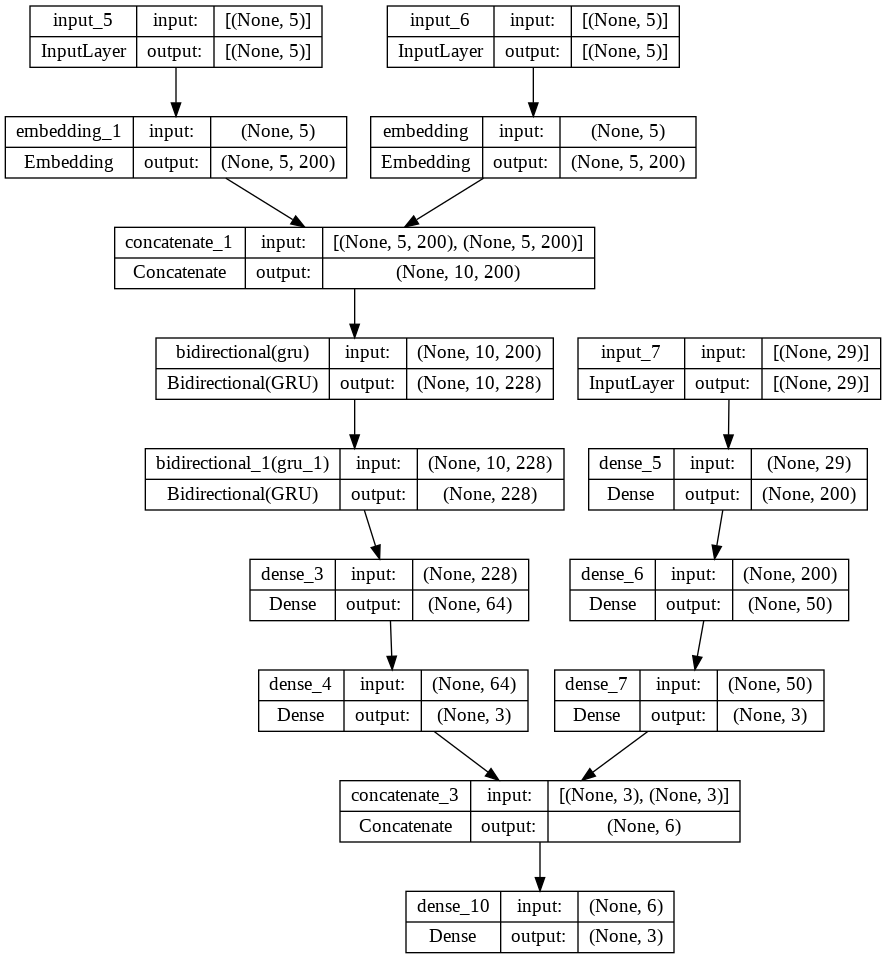

In [ ]:
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
x_test = vectorizer(np.array([[s] for s in test_samples_chief])).numpy()
x_test_his = vectorizer_his(np.array([[s] for s in test_samples_his])).numpy()
x_test_o = trans_pip.transform(test_samples_o)
y_test = np.array(y_test)

In [ ]:
y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
y_test_pred = model.predict(x=[x_test_o,[x_test_his, x_test]])

# print("roc auc for validation set:", roc_auc_score(y_test, y_test_pred))
# y_pred_test_class = np.where(y_test_pred> 0.5, 1, 0)
# print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
# print("f1 score for test set:", f1_score(y_test, y_pred_test_class))
# confusion_matrix(y_test, y_pred_test_class)

y_test_pred

815/815 [==============================] - 4s 4ms/step


array([[0.00179224, 0.99371874, 0.00448911],
       [0.00706055, 0.9722145 , 0.02072496],
       [0.00104703, 0.9963767 , 0.00257622],
       ...,
       [0.03573242, 0.8549883 , 0.10927926],
       [0.03362165, 0.86024046, 0.10613786],
       [0.00404362, 0.98509395, 0.01086232]], dtype=float32)

In [ ]:
# max_value = max(a_list)
# max_index = x.index(max(x))

test= [[0,0,1], [0.6,0.2,0]]
test_list = [list(i).index(max(list(i))) for i in y_test]
pred_list = [list(i).index(max(list(i))) for i in y_test_pred]

print("accuracy score for test set:", accuracy_score(test_list, pred_list))
print("f1 score for test set:", f1_score(test_list, pred_list, average='weighted'))

accuracy score for test set: 0.7439852653390123
f1 score for test set: 0.6803583576943638


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_list, pred_list), 
                              display_labels=['Beyond\na Week', 'Within\nToday', 'Within the\nWeek'])
disp.plot()
plt.show()
weights

NameError: ignored

In [ ]:
loaded_1 = keras.models.load_model("/content/drive/MyDrive/Capstone_project/model_2b.h5")


In [ ]:
# weights = {0:1-(sum(y_train)/len(y_train)),1:sum(y_train)/len(y_train)}

In [ ]:
y_test_pred = loaded_1.predict(x=[x_test_o,x_test_his, x_test])

print("roc auc for validation set:", roc_auc_score(y_test, y_test_pred))
y_pred_test_class = np.where(y_test_pred> 0.5, 1, 0)
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
print("f1 score for test set:", f1_score(y_test, y_pred_test_class))
confusion_matrix(y_test, y_pred_test_class)


In [ ]:
y_test_pred = loaded_1.predict(x=[x_test_o,x_test_his, x_test])

print("roc auc for validation set:", roc_auc_score(y_test, y_test_pred))
y_pred_test_class = np.where(y_test_pred> weights[1], 1, 0)
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
print("f1 score for test set:", f1_score(y_test, y_pred_test_class))
confusion_matrix(y_test, y_pred_test_class)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_class), display_labels = ["Home","Admitted"])
disp.plot()
plt.show()

In [ ]:
pd.DataFrame(x_test_o).to_csv("x_test_o.csv",index=False)
pd.DataFrame(x_test).to_csv("x_test.csv",index=False)
pd.DataFrame(x_test_his).to_csv("x_test_his.csv",index=False)
pd.DataFrame(train_samples_o).to_csv("train_samples_o.csv",index=False)
pd.DataFrame(test_samples_his).to_csv("test_samples_his.csv",index=False)
pd.DataFrame(test_samples_chief).to_csv("test_samples_chief.csv",index=False)
pd.DataFrame(edstay_ad1).to_csv("edstay_ad1.csv",index=False)
pd.DataFrame(updated_edstay_ad).to_csv("updated_edstay_ad.csv",index=False)
pd.DataFrame(triage_3).to_csv("updated_edstay_ad.csv",index=False)

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
import shap
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
explainer = shap.DeepExplainer(model, [x_test_o[:1000],x_test_his[:1000],x_test[:1000]])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



TypeError: ignored

In [ ]:
shap.initjs()

shap_values = explainer.shap_values([x_test_o[:500],x_test_his[:500],x_test[:500]])

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
# lazy XGBoost for admitted
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBClassifier()

In [ ]:
xgb_model.fit(x_train_o, train_labels)

In [ ]:
edstay_ad1 = edstay_ad.drop(['Unnamed: 0','hadm_id','intime', 'intime_h','outtime','race', 'disposition','y_var_adm_text','key', 'DateTime_in', 'DateTime_out','stay','historical_stay_length','chiefcomplaint',
                             'subjects_entering', 'subjects_leaving', 'intime', 'in_date','out_date'], axis = 1)

In [ ]:
edstay_ad1['gender'] = pd.Categorical(edstay_ad1['gender'])
edstay_ad1['arrival_transport'] = pd.Categorical(edstay_ad1['arrival_transport'])
edstay_ad1['race_class'] = pd.Categorical(edstay_ad1['race_class'])
edstay_ad1['historical_stay_status'] = pd.Categorical(edstay_ad1['historical_stay_status'])
edstay_ad1.info()

In [ ]:
edstay_ad.to_csv('Admission_ForXGB.csv')
edstay_ad.columns

In [ ]:
y_labels = edstay_ad1['y_var']

X = edstay_ad1.drop(['subject_id','stay_id','y_var'], axis=1)
X = pd.get_dummies(X)

import numpy as np

for col in X.columns:
  val = np.mean(X[col])
  X[col] = X[col].fillna(val)

X_train, X_test, y_train, y_test  = train_test_split(X, y_labels, test_size=0.7, stratify=y_labels)
X.info()

In [ ]:
from sklearn.metrics import accuracy_score,f1_score

from sklearn.ensemble import RandomForestClassifier

# Init classifier
xgb_cl = xgb.XGBClassifier()
ran = RandomForestClassifier()

# Fit
xgb_cl.fit(X_train, y_train)
ran.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)
preds2 = ran.predict(X_test)
# Score
print('XGB\nAcc:',accuracy_score(y_test, preds))
print('F1:',f1_score(y_test, preds))

print('RF\nAcc:',accuracy_score(y_test, preds2))
print('F1:',f1_score(y_test, preds2))


ValueError: ignored

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(preds, y_test), display_labels = ["Home","Admitted"])
disp.plot()
plt.show()

In [ ]:
explainer = shap.Explainer(xgb_cl)

In [ ]:
shap_values = explainer(X_train)

In [ ]:
shap.plots.beeswarm(shap_values, max_display=20)

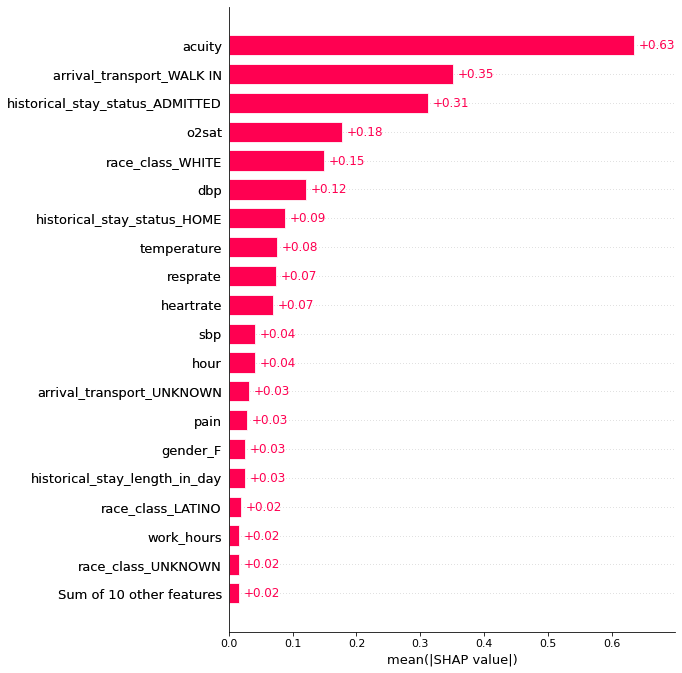

In [ ]:
shap.plots.bar(shap_values, max_display=20)

In [ ]:
# lazy xgb for length of stay 3 class
edstay_ad2 = edstay_ad.drop(['Unnamed: 0','hadm_id','intime', 'intime_h','outtime','race', 'y_var_adm_text','key', 'DateTime_in', 'DateTime_out','historical_stay_length','chiefcomplaint',
                             'subjects_entering', 'subjects_leaving', 'intime'], axis = 1)
from datetime import datetime

edstay_ad2.in_date = pd.to_datetime(edstay_ad2.in_date)
edstay_ad2.out_date = pd.to_datetime(edstay_ad2.out_date)
diff = edstay_ad2.out_date - edstay_ad2.in_date
edstay_ad2['nights'] = [d.days for d in diff]

def reclass_nights(x):
  if x['nights'] > 7:
    return 'Beyond a Week'
  elif x['nights'] == 0: 
    return 'Within Today'
  else:
    return 'Within the Week'

edstay_ad2['Y'] = edstay_ad2.apply(reclass_nights, axis=1)
edstay_ad2[['in_date','out_date','nights','Y']]
edstay_ad2['Y'] = pd.Categorical(edstay_ad2['Y'], categories = ['Beyond a Week', 'Within the Week', 'Within Today'])
edstay_ad2_filt = edstay_ad2[edstay_ad2.disposition.isin(['ADMITTED','TRANSFER'])]

In [ ]:

# edstay_ad2_filt.info()
edstay_ad2_filt.Y.value_counts()

Within Today       115682
Within the Week     37183
Beyond a Week       20874
Name: Y, dtype: int64

In [ ]:
edstay_ad2_filt.to_csv('LengthOfStay_ForXGB.csv')

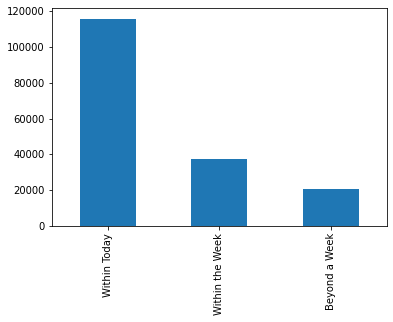

In [ ]:
all_data_los.Y.value_counts().plot(kind='bar')

Acc: 0.7598957391175648
F1: 0.7103739343009159


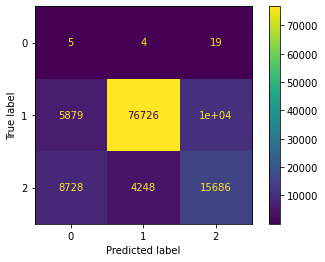

In [ ]:
y_labels = edstay_ad2_filt['Y']

  from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_labels)
y_labels = le.transform(y_labels)

X = edstay_ad2_filt.drop(['subject_id','stay_id','y_var', 'disposition', 'Y','y_var','nights','in_date','out_date','stay'], axis=1)
X = pd.get_dummies(X)

import numpy as np

for col in X.columns:
  val = np.mean(X[col])
  X[col] = X[col].fillna(val)

X_train, X_test, y_train, y_test  = train_test_split(X, y_labels, test_size=0.7, stratify=y_labels)

from sklearn.metrics import accuracy_score,f1_score

from sklearn.ensemble import RandomForestClassifier

# Init classifier
xgb_cl = xgb.XGBClassifier()
# ran = RandomForestClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
print('Acc:',accuracy_score(y_test, preds))
print('F1:',f1_score(y_test, preds, average = 'weighted'))

disp = ConfusionMatrixDisplay(confusion_matrix(preds, y_test))
disp.plot()
plt.show()

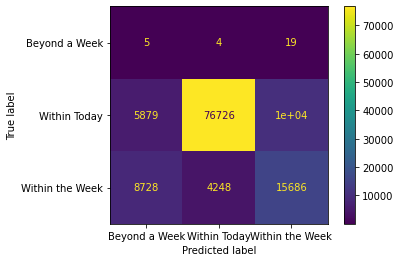

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(preds, y_test), display_labels=['Beyond a Week', 'Within Today','Within the Week'])
disp.plot()

In [ ]:
decoded = le.inverse_transform(preds)
print(decoded[:10])
print(preds[:10])

['Within Today' 'Within the Week' 'Within Today' 'Within Today'
 'Within the Week' 'Within Today' 'Within Today' 'Within the Week'
 'Within Today' 'Within Today']
[1 2 1 1 2 1 1 2 1 1]


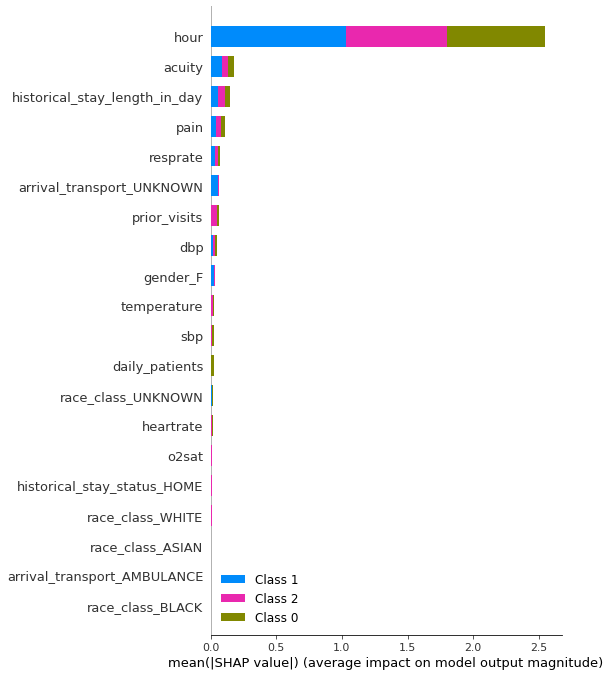

In [ ]:
shap_values = shap.TreeExplainer(xgb_cl).shap_values(X_test)
shap.summary_plot(shap_values, X_test)